***
<font size="6"><center><b> B-CNN: FMNIST Model B </b></center></font>
***

# Imports Necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
    #import other libraries
import math
import random

sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models
from treelib import Tree

DONE loading MixUp Data generator
DONE loading MixUp Data generator


## LOG File Directory

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5,6,7"

In [3]:
base_path = "./logs/B_CNN"
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print("FOLDER CREATED = ", base_path)
else:
    print("Warning: Folder already exist.")

FOLDER CREATED =  ./logs/B_CNN


### For GPU growth (not required if GPU does not give any error)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Done: GPU "+str(gpu))
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [5]:
def scheduler(epoch):
  learning_rate_init = 0.003
  if epoch > 40:
    learning_rate_init = 0.0005
  if epoch > 50:
    learning_rate_init = 0.0001
  return learning_rate_init

In [6]:
class LossWeightsModifier(keras.callbacks.Callback):
  def __init__(self, alpha, beta, gamma):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 8:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.8)
      K.set_value(self.gamma, 0.1)
    if epoch == 18:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.2)
      K.set_value(self.gamma, 0.7)
    if epoch == 28:
      K.set_value(self.alpha, 0)
      K.set_value(self.beta, 0)
      K.set_value(self.gamma, 1)

In [7]:
#-------- dimensions ---------
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
#-----------------------------

train_size = 60000

#--- coarse 1 classes ---
num_c_1 = 2
#--- coarse 2 classes ---
num_c_2 = 6
#--- fine classes ---
num_classes  = 10

batch_size   = 1400
epochs       = 100

#--- file paths ---
log_filepath = base_path+'/tb_logs/'
weights_store_filepath = base_path+'/model_weights/'

In [8]:
#-------------------- data loading ----------------------
F_MNIST = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = F_MNIST.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#---------------- data preprocessiong -------------------
x_train = (x_train-np.mean(x_train)) / np.std(x_train)
x_test = (x_test-np.mean(x_test)) / np.std(x_test)

#---------------------- make coarse 2 labels --------------------------
parent_f = {0:0, 1:1, 2:0, 3:2, 4:3, 5:5, 6:0, 7:5, 8:4, 9:5}
y_c2_train = np.zeros((y_train.shape[0], num_c_2)).astype("float32")
y_c2_test = np.zeros((y_test.shape[0], num_c_2)).astype("float32")
for i in range(y_c2_train.shape[0]):
  y_c2_train[i][parent_f[np.argmax(y_train[i])]] = 1.0
for i in range(y_c2_test.shape[0]):
  y_c2_test[i][parent_f[np.argmax(y_test[i])]] = 1.0

#---------------------- make coarse 1 labels --------------------------
parent_c2 = {0:0, 1:0, 2:0, 3:0, 4:1, 5:1}
y_c1_train = np.zeros((y_c2_train.shape[0], num_c_1)).astype("float32")
y_c1_test = np.zeros((y_c2_test.shape[0], num_c_1)).astype("float32")
for i in range(y_c1_train.shape[0]):
  y_c1_train[i][parent_c2[np.argmax(y_c2_train[i])]] = 1.0
for i in range(y_c1_test.shape[0]):
  y_c1_test[i][parent_c2[np.argmax(y_c2_test[i])]] = 1.0

In [9]:
#----------------------- model definition ---------------------------
alpha = K.variable(value=0.98, dtype="float32", name="alpha") # A1 in paper
beta = K.variable(value=0.01, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.01, dtype="float32", name="gamma") # A3 in paper

In [10]:
img_input = Input(shape=input_shape, name='input')

#--- block 1 ---
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#--- block 2 ---
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#--- coarse 1 branch ---
c_1_bch = Flatten(name='c1_flatten')(x)
c_1_bch = Dense(256, activation='relu', name='c1_fc_cifar10_1')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_bch = Dense(256, activation='relu', name='c1_fc2')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_pred = Dense(num_c_1, activation='softmax', name='c1_predictions_cifar10')(c_1_bch)

#--- block 3 ---
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#--- coarse 2 branch ---
c_2_bch = Flatten(name='c2_flatten')(x)
c_2_bch = Dense(512, activation='relu', name='c2_fc_cifar10_1')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_bch = Dense(512, activation='relu', name='c2_fc2')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_pred = Dense(num_c_2, activation='softmax', name='c2_predictions_cifar10')(c_2_bch)

#--- block 4 ---
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#--- fine block ---
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc_cifar10_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
fine_pred = Dense(num_classes, activation='softmax', name='predictions_cifar10')(x)

In [11]:
model = Model(img_input, [c_1_pred, c_2_pred, fine_pred], name='medium_dynamic')

In [12]:
model.summary()

Model: "medium_dynamic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalizatio

                                                                                                  
 fc2 (Dense)                    (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256)         1024        ['c1_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 512)         2048        ['c2_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_13 (BatchN  (None, 1024)        4096        ['fc2[0][0]']                    
 ormalizat

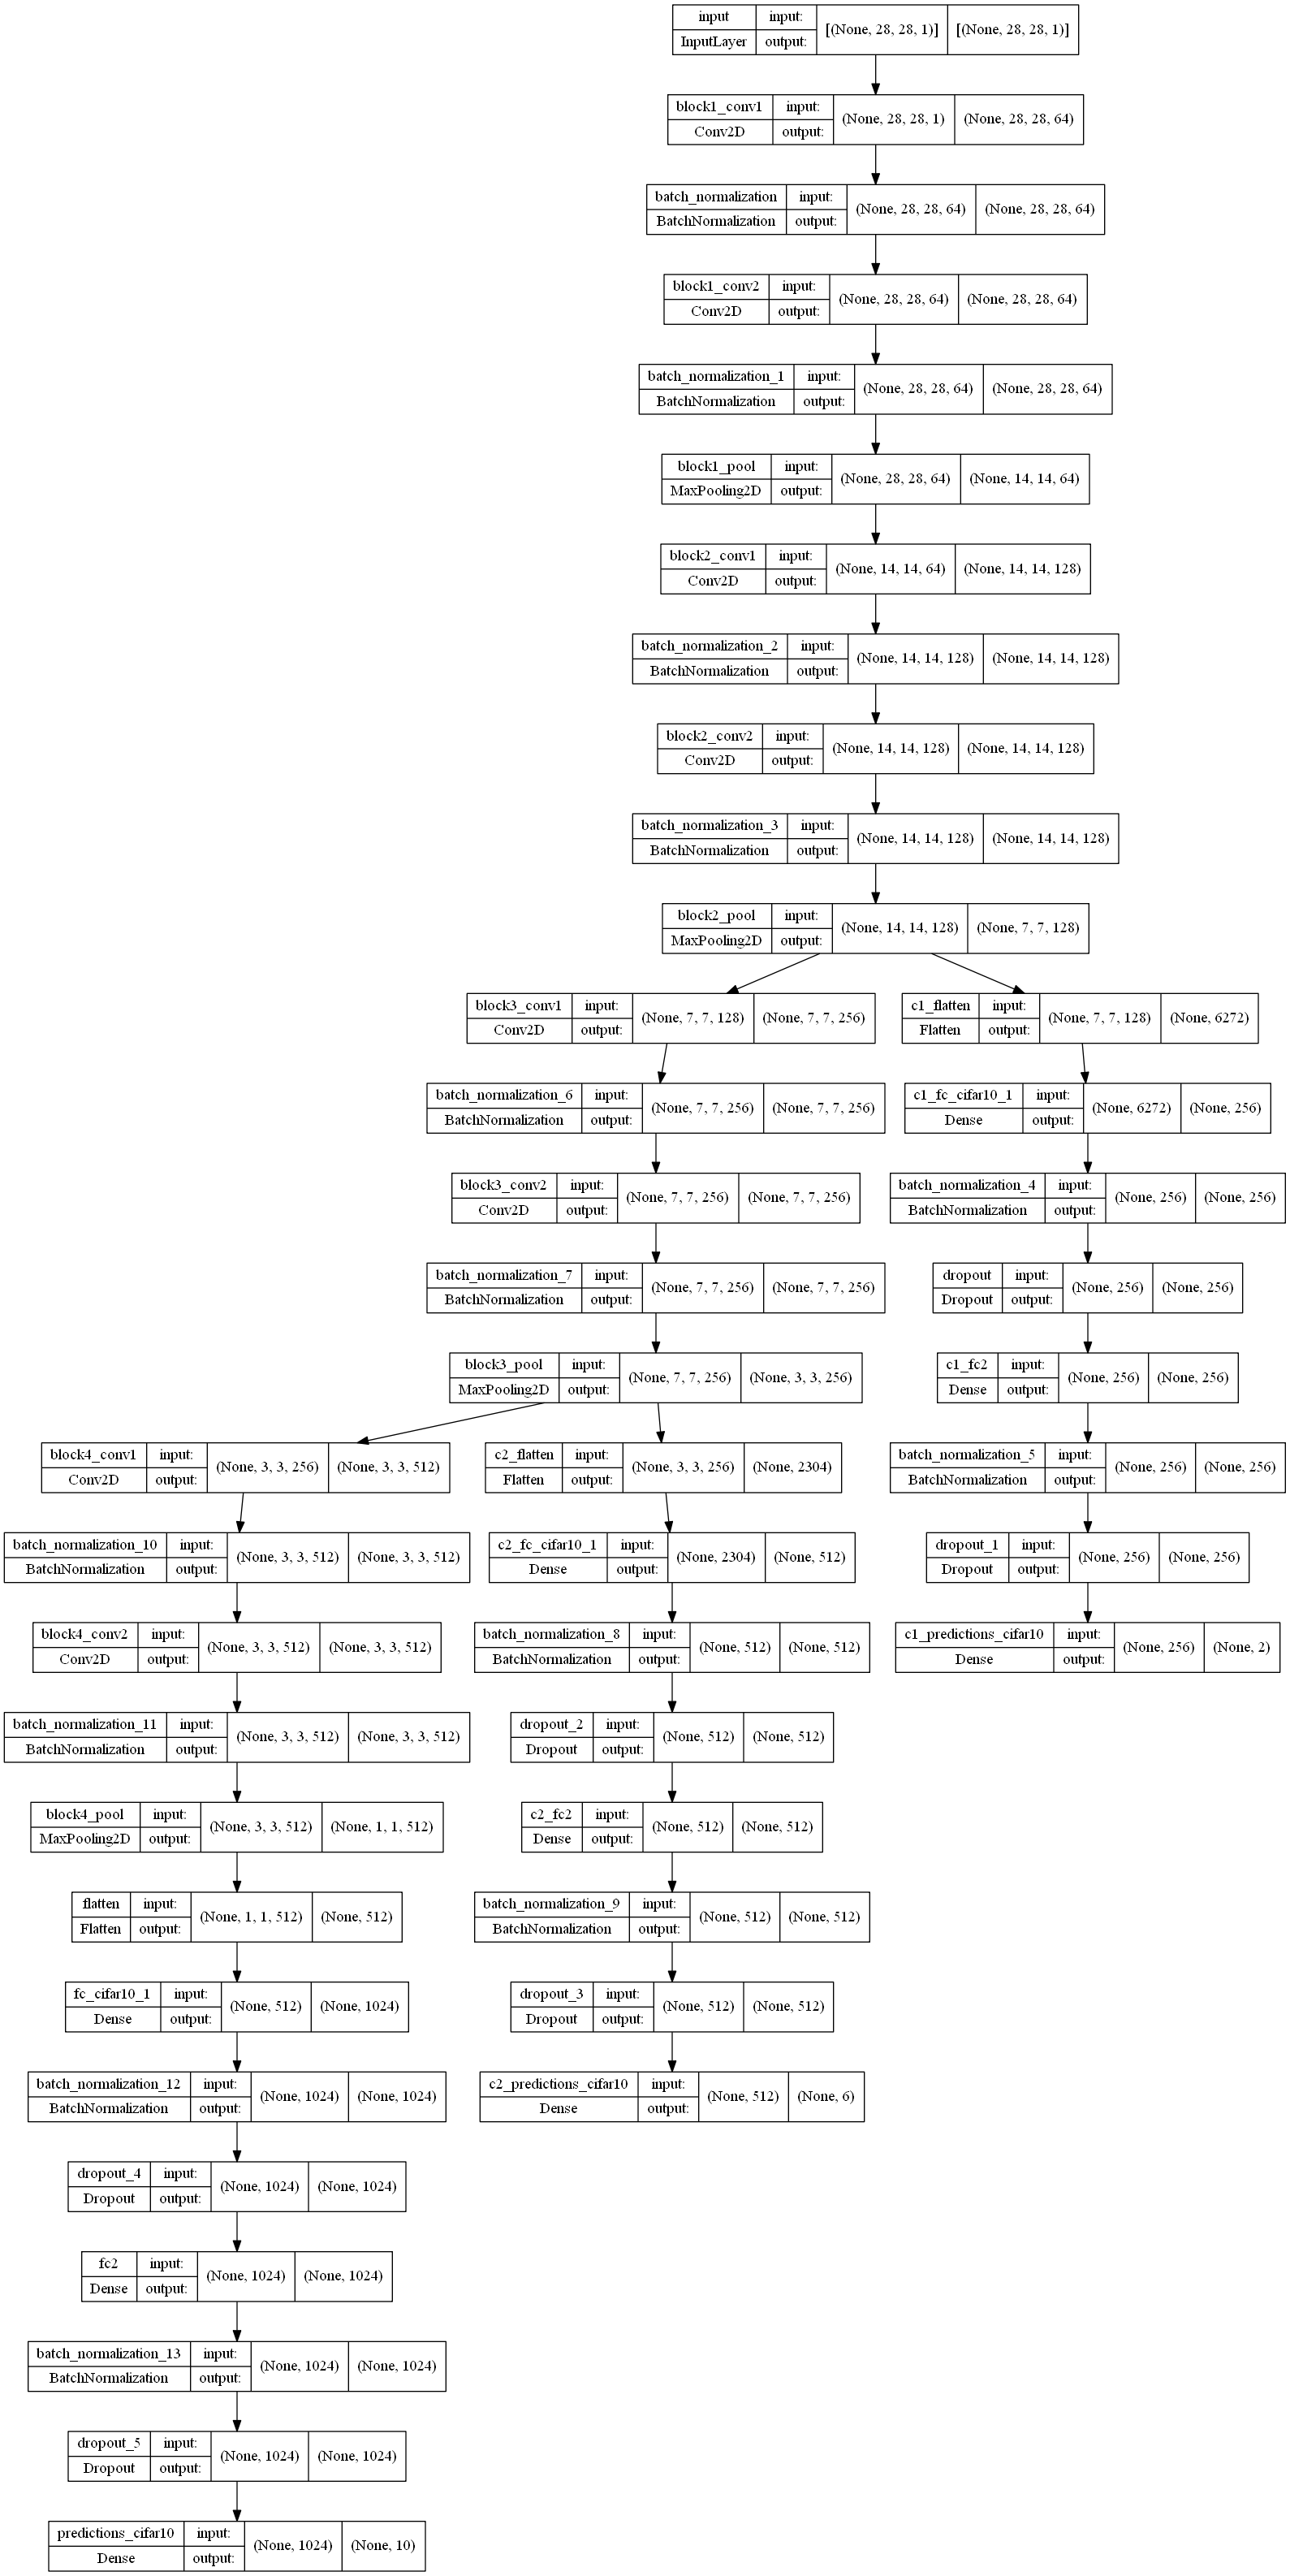

In [13]:
keras.utils.plot_model(model, base_path+"/b-cnn.png",show_shapes=True)

In [14]:
#----------------------- compile and fit ---------------------------
sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              loss_weights=[alpha, beta, gamma],
              # optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

log = keras.callbacks.CSVLogger(base_path+'/log.csv', append=True)
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
cbks = [change_lr, tb_cb, change_lw, log]

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
try:
    model.load_weights(base_path+'/trained_model.h5')
except:
    model.fit(x_train, [y_c1_train, y_c2_train, y_train],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=cbks,
              validation_data=(x_test, [y_c1_test, y_c2_test, y_test]))
    model.save_weights(base_path+'/trained_model.h5')

Epoch 1/100
43/43 [==============================] - 22s 305ms/step - loss: 0.1732 - c1_predictions_cifar10_loss: 0.1201 - c2_predictions_cifar10_loss: 2.3668 - predictions_cifar10_loss: 3.1881 - c1_predictions_cifar10_accuracy: 0.9556 - c2_predictions_cifar10_accuracy: 0.2919 - predictions_cifar10_accuracy: 0.1712 - val_loss: 0.6670 - val_c1_predictions_cifar10_loss: 0.6377 - val_c2_predictions_cifar10_loss: 1.8876 - val_predictions_cifar10_loss: 2.3272 - val_c1_predictions_cifar10_accuracy: 0.4736 - val_c2_predictions_cifar10_accuracy: 0.1001 - val_predictions_cifar10_accuracy: 0.1000 - lr: 0.0030
Epoch 2/100
43/43 [==============================] - 7s 169ms/step - loss: 0.0710 - c1_predictions_cifar10_loss: 0.0359 - c2_predictions_cifar10_loss: 1.4731 - predictions_cifar10_loss: 2.1065 - c1_predictions_cifar10_accuracy: 0.9894 - c2_predictions_cifar10_accuracy: 0.5078 - predictions_cifar10_accuracy: 0.3738 - val_loss: 0.6734 - val_c1_predictions_cifar10_loss: 0.6428 - val_c2_predict

Epoch 14/100
43/43 [==============================] - 7s 170ms/step - loss: 0.2045 - c1_predictions_cifar10_loss: 0.0197 - c2_predictions_cifar10_loss: 0.1889 - predictions_cifar10_loss: 0.5143 - c1_predictions_cifar10_accuracy: 0.9944 - c2_predictions_cifar10_accuracy: 0.9323 - predictions_cifar10_accuracy: 0.8275 - val_loss: 0.1886 - val_c1_predictions_cifar10_loss: 0.0160 - val_c2_predictions_cifar10_loss: 0.1822 - val_predictions_cifar10_loss: 0.4128 - val_c1_predictions_cifar10_accuracy: 0.9951 - val_c2_predictions_cifar10_accuracy: 0.9318 - val_predictions_cifar10_accuracy: 0.8533 - lr: 0.0030
Epoch 15/100
43/43 [==============================] - 7s 169ms/step - loss: 0.1917 - c1_predictions_cifar10_loss: 0.0183 - c2_predictions_cifar10_loss: 0.1770 - predictions_cifar10_loss: 0.4828 - c1_predictions_cifar10_accuracy: 0.9947 - c2_predictions_cifar10_accuracy: 0.9359 - predictions_cifar10_accuracy: 0.8387 - val_loss: 0.1713 - val_c1_predictions_cifar10_loss: 0.0156 - val_c2_predic

Epoch 41/100
43/43 [==============================] - 7s 166ms/step - loss: 0.0172 - c1_predictions_cifar10_loss: 0.0169 - c2_predictions_cifar10_loss: 0.1122 - predictions_cifar10_loss: 0.0172 - c1_predictions_cifar10_accuracy: 0.9953 - c2_predictions_cifar10_accuracy: 0.9588 - predictions_cifar10_accuracy: 0.9950 - val_loss: 0.3581 - val_c1_predictions_cifar10_loss: 0.0146 - val_c2_predictions_cifar10_loss: 0.1305 - val_predictions_cifar10_loss: 0.3581 - val_c1_predictions_cifar10_accuracy: 0.9962 - val_c2_predictions_cifar10_accuracy: 0.9529 - val_predictions_cifar10_accuracy: 0.9196 - lr: 0.0030
Epoch 42/100
43/43 [==============================] - 7s 165ms/step - loss: 0.0162 - c1_predictions_cifar10_loss: 0.0170 - c2_predictions_cifar10_loss: 0.1121 - predictions_cifar10_loss: 0.0162 - c1_predictions_cifar10_accuracy: 0.9951 - c2_predictions_cifar10_accuracy: 0.9587 - predictions_cifar10_accuracy: 0.9950 - val_loss: 0.3546 - val_c1_predictions_cifar10_loss: 0.0143 - val_c2_predic

43/43 [==============================] - 7s 169ms/step - loss: 0.0042 - c1_predictions_cifar10_loss: 0.0173 - c2_predictions_cifar10_loss: 0.1075 - predictions_cifar10_loss: 0.0042 - c1_predictions_cifar10_accuracy: 0.9953 - c2_predictions_cifar10_accuracy: 0.9610 - predictions_cifar10_accuracy: 0.9995 - val_loss: 0.3747 - val_c1_predictions_cifar10_loss: 0.0142 - val_c2_predictions_cifar10_loss: 0.1270 - val_predictions_cifar10_loss: 0.3747 - val_c1_predictions_cifar10_accuracy: 0.9963 - val_c2_predictions_cifar10_accuracy: 0.9548 - val_predictions_cifar10_accuracy: 0.9225 - lr: 1.0000e-04
Epoch 68/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0040 - c1_predictions_cifar10_loss: 0.0165 - c2_predictions_cifar10_loss: 0.1073 - predictions_cifar10_loss: 0.0040 - c1_predictions_cifar10_accuracy: 0.9955 - c2_predictions_cifar10_accuracy: 0.9618 - predictions_cifar10_accuracy: 0.9994 - val_loss: 0.3736 - val_c1_predictions_cifar10_loss: 0.0142 - val_c2_predictions_cif

43/43 [==============================] - 7s 169ms/step - loss: 0.0036 - c1_predictions_cifar10_loss: 0.0162 - c2_predictions_cifar10_loss: 0.1088 - predictions_cifar10_loss: 0.0036 - c1_predictions_cifar10_accuracy: 0.9954 - c2_predictions_cifar10_accuracy: 0.9606 - predictions_cifar10_accuracy: 0.9996 - val_loss: 0.3796 - val_c1_predictions_cifar10_loss: 0.0142 - val_c2_predictions_cifar10_loss: 0.1268 - val_predictions_cifar10_loss: 0.3796 - val_c1_predictions_cifar10_accuracy: 0.9962 - val_c2_predictions_cifar10_accuracy: 0.9547 - val_predictions_cifar10_accuracy: 0.9237 - lr: 1.0000e-04
Epoch 94/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0035 - c1_predictions_cifar10_loss: 0.0165 - c2_predictions_cifar10_loss: 0.1087 - predictions_cifar10_loss: 0.0035 - c1_predictions_cifar10_accuracy: 0.9952 - c2_predictions_cifar10_accuracy: 0.9609 - predictions_cifar10_accuracy: 0.9997 - val_loss: 0.3788 - val_c1_predictions_cifar10_loss: 0.0142 - val_c2_predictions_cif

TypeError: Unable to serialize <tf.Variable 'alpha:0' shape=() dtype=float32, numpy=0.0> to JSON. Unrecognized type <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>.

In [18]:
score = model.evaluate(x_test, [y_c1_test, y_c2_test, y_test], verbose=0)
print('score is: ', score)

score is:  [0.3791400194168091, 0.014204118400812149, 0.12689638137817383, 0.3791400194168091, 0.9962999820709229, 0.9544000029563904, 0.92330002784729]


In [19]:
for n in range(len(score)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', score[n])

1. loss ==> 0.3791400194168091
2. c1_predictions_cifar10_loss ==> 0.014204118400812149
3. c2_predictions_cifar10_loss ==> 0.12689638137817383
4. predictions_cifar10_loss ==> 0.3791400194168091
5. c1_predictions_cifar10_accuracy ==> 0.9962999820709229
6. c2_predictions_cifar10_accuracy ==> 0.9544000029563904
7. predictions_cifar10_accuracy ==> 0.92330002784729


# Precision & Recall

In [20]:
predictions = model.predict(x_test, verbose=1)
for n in range(len(predictions)):
    print(str(n+1)+'.',predictions[n].shape, '==>', 'predictions[{A}]'.format(A=n))

313/313 [==============================] - 3s 8ms/step
1. (10000, 2) ==> predictions[0]
2. (10000, 6) ==> predictions[1]
3. (10000, 10) ==> predictions[2]


# sklearn: Performance parameters

{0, 1}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[0, 1]
['0', '1']
[0, 1, 2, 3, 4, 5]
['0', '1', '2', '3', '4', '5']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

  • multilabel-Confusion_Matrix 


  • COARSE LEVEL 
[[[3982   18]
  [  19 5981]]

 [[5981   19]
  [  18 3982]]]

  • MEDIUM LEVEL 
[[[6795  205]
  [ 167 2833]]

 [[8994    6]
  [  24  976]]

 [[8928   72]
  [ 102  898]]

 [[8847  153]
  [ 134  866]]

 [[8986   14]
  [  26  974]]

 [[6994    6]
  [   3 2997]]]

  • FINE LEVEL 
[[[8873  127]
  [ 138  862]]

 [[8997    3]
  [  24  976]]

 [[8890  110]
  [ 101  899]]

 [[8891  109]
  [  65  935]]

 [[8880  120]
  [ 109  891]]

 [[8984   16]
  [  17  983]]

 [[8793  207]
  [ 244  756]]

 [[8961   39]
  [  23  977]]

 [[8985   15]
  [  15  985]]

 [[8979   21]
  [  31  969]]]

  • Confusion_Matrix 


  • COARSE LEVEL 
[[5981   19]
 [  18 3982]]

  • MEDIUM LEVEL 
[[2833    1   35  122    9    0]
 [   7  976   13    3    1    0]
 [  73  

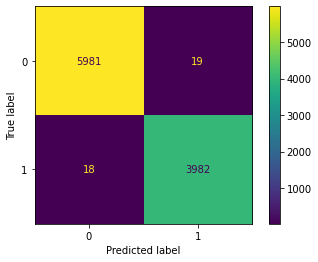

              precision    recall  f1-score   support

           0    0.99700   0.99683   0.99692      6000
           1    0.99525   0.99550   0.99538      4000

    accuracy                        0.99630     10000
   macro avg    0.99613   0.99617   0.99615     10000
weighted avg    0.99630   0.99630   0.99630     10000


  • MEDIUM LEVEL 


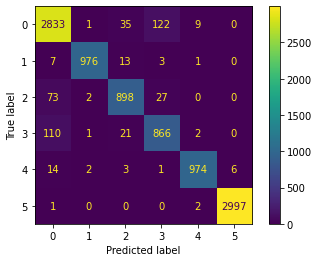

              precision    recall  f1-score   support

           0    0.93252   0.94433   0.93839      3000
           1    0.99389   0.97600   0.98486      1000
           2    0.92577   0.89800   0.91168      1000
           3    0.84985   0.86600   0.85785      1000
           4    0.98583   0.97400   0.97988      1000
           5    0.99800   0.99900   0.99850      3000

    accuracy                        0.95440     10000
   macro avg    0.94764   0.94289   0.94519     10000
weighted avg    0.95469   0.95440   0.95449     10000


  • FINE LEVEL 


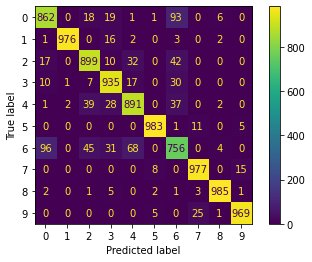

              precision    recall  f1-score   support

           0    0.87159   0.86200   0.86677      1000
           1    0.99694   0.97600   0.98636      1000
           2    0.89098   0.89900   0.89497      1000
           3    0.89559   0.93500   0.91487      1000
           4    0.88131   0.89100   0.88613      1000
           5    0.98398   0.98300   0.98349      1000
           6    0.78505   0.75600   0.77025      1000
           7    0.96161   0.97700   0.96925      1000
           8    0.98500   0.98500   0.98500      1000
           9    0.97879   0.96900   0.97387      1000

    accuracy                        0.92330     10000
   macro avg    0.92308   0.92330   0.92310     10000
weighted avg    0.92308   0.92330   0.92310     10000



In [21]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

cloarse_classes_number = num_c_1 #from model architecture
medium_classes_number = num_c_2
fine_classes_number = num_classes

y_true_coarse = np.argmax(y_c1_test, axis=1)
y_pred_coarse = np.argmax(predictions[0], axis=1)

y_true_medium = np.argmax(y_c2_test, axis=1)
y_pred_medium = np.argmax(predictions[1], axis=1)

y_true_fine = np.argmax(y_test, axis=1)
y_pred_fine = np.argmax(predictions[2], axis=1)

output = set()
for x in y_true_coarse:
    output.add(x)
print(output)

for x in y_true_medium:
    output.add(x)
print(output)

for x in y_true_fine:
    output.add(x)
print(output)

coarse_labels = list(range(0, cloarse_classes_number))
coarse_target_names = [str(x) for x in list(range(0, cloarse_classes_number))]
medium_labels = list(range(0, medium_classes_number))
medium_target_names = [str(x) for x in list(range(0, medium_classes_number))]
fine_labels = list(range(0, fine_classes_number))
fine_target_names = [str(x) for x in list(range(0, fine_classes_number))]
print(coarse_labels)
print(coarse_target_names)
print(medium_labels)
print(medium_target_names)
print(fine_labels)
print(fine_target_names)

def confusion_matrixDisplay(y_true, y_pred, target_names):
    labels = target_names
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.show()
    #plt.savefig("Confusion_Matrix.png")

print('\n\033[91m','\033[1m',"\u2022",'multilabel-Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Classification Report','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_coarse, y_pred_coarse, coarse_target_names)
print(classification_report(y_true_coarse, y_pred_coarse, target_names=coarse_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
confusion_matrixDisplay(y_true_medium, y_pred_medium, medium_target_names)
print(classification_report(y_true_medium, y_pred_medium, target_names=medium_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_fine, y_pred_fine, fine_target_names)
print(classification_report(y_true_fine, y_pred_fine, target_names=fine_target_names, digits=5))

# hierarchical_PrecisionRecallF1

In [22]:
tree = Tree()
tree.create_node("Root", "root")  # root node
for i in range(2):
    tree.create_node('L0_'+ str(i), 'L0_'+ str(i), parent="root")

def mediumlevel(previous_lvl, new_lvl):
    
    tree.create_node('L1_'+str(new_lvl), 'L1_'+str(new_lvl), 'L0_'+str(previous_lvl))

def finelevel(previous_lvl, new_lvl):
    
    tree.create_node('L2_'+str(new_lvl), 'L2_'+str(new_lvl), 'L1_'+str(previous_lvl))

for i in range(len(parent_c2)):
    mediumlevel(parent_c2[i], i)

for i in range(len(parent_f)):
    finelevel(parent_f[i], i)
tree.show()

Root
├── L0_0
│   ├── L1_0
│   │   ├── L2_0
│   │   ├── L2_2
│   │   └── L2_6
│   ├── L1_1
│   │   └── L2_1
│   ├── L1_2
│   │   └── L2_3
│   └── L1_3
│       └── L2_4
└── L0_1
    ├── L1_4
    │   └── L2_8
    └── L1_5
        ├── L2_5
        ├── L2_7
        └── L2_9



In [23]:
true_label = [y_true_coarse.tolist(), y_true_medium.tolist(), y_true_fine.tolist()]
pred_label = [predictions[0],predictions[1],predictions[2]]

In [24]:
h_measurements = metrics.get_hierarchical_metrics(true_label, pred_label, tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2])
print('\nH Accuracy=',
     metrics.get_h_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',)

print('\nM Accuracy=',
     metrics.get_m_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',
      )

print('\nExact_Match=',
     metrics.get_exact_match(true_label, pred_label),
     '\nThis method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.',
      )

print('\nConsistency=',
     metrics.get_consistency(pred_label, tree),
     '\nThis methods estimates the consistency.',
      )


Hierarchical Precision = 0.9576783333333333 
Hierarchical Recall = 0.9647666666666668 
Hierarchical F1-Score = 0.9606761904761905

H Accuracy= 0.9570708911193418 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

M Accuracy= 0.9579999999999999 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

Exact_Match= 0.9044 
This method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.

Consistency= 0.9673 
This methods estimates the consistency.
